# Hi kagglers 🙋🏻‍♂️ and Welcome to this new competition!

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tabular-playground-series-oct-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-oct-2021/train.csv
/kaggle/input/tabular-playground-series-oct-2021/test.csv


In [4]:
import random
import gc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,StratifiedKFold
from lightgbm import LGBMClassifier

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn import preprocessing
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
train = pd.read_csv('/kaggle/input/tabular-playground-series-oct-2021/train.csv')
test = pd.read_csv('/kaggle/input/tabular-playground-series-oct-2021/test.csv')
sub = pd.read_csv('/kaggle/input/tabular-playground-series-oct-2021/sample_submission.csv')
y = train['target']

# Let's do some Exploratory Data Analysis (EDA)

In [4]:
train.head()

,id,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f276,f277,f278,f279,f280,f281,f282,f283,f284,target
0,0,0.205979,0.410993,0.176775,0.223581,0.423543,0.476140,0.413590,0.612021,0.534873,...,0,1,0,0,0,0,0,0,0,1
1,1,0.181004,0.473119,0.011734,0.213657,0.619678,0.441593,0.230407,0.686013,0.281971,...,0,1,0,0,0,0,0,0,0,1
2,2,0.182583,0.307431,0.325950,0.207116,0.605699,0.309695,0.493337,0.751107,0.536272,...,0,0,0,1,1,0,0,0,0,1
3,3,0.180240,0.494592,0.008367,0.223580,0.760618,0.439211,0.432055,0.776147,0.483958,...,0,0,0,0,1,0,0,0,0,1
4,4,0.177172,0.495513,0.014263,0.548819,0.625396,0.562493,0.117158,0.561255,0.077115,...,0,1,1,0,1,0,0,1,0,1


In [5]:
test.head()

,id,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f275,f276,f277,f278,f279,f280,f281,f282,f283,f284
0,1000000,0.178216,0.435617,0.010230,0.202074,0.390170,0.324221,0.221722,0.738894,0.582588,...,1,0,0,0,0,0,1,1,1,0
1,1000001,0.181250,0.476455,0.022413,0.283146,0.598020,0.349508,0.283467,0.721575,0.268990,...,0,0,0,0,0,0,0,0,0,0
2,1000002,0.159721,0.451202,0.259649,0.365274,0.594634,0.413502,0.249318,0.642339,0.411104,...,0,0,0,0,0,0,1,0,0,0
3,1000003,0.182424,0.520976,0.095344,0.327742,0.741830,0.358711,0.270077,0.601662,0.297742,...,0,0,0,0,0,1,1,0,0,0
4,1000004,0.229329,0.336513,0.023511,0.300913,0.668738,0.481586,0.545660,0.667849,0.546045,...,0,0,0,0,1,0,0,1,0,0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Columns: 287 entries, id to target
dtypes: float64(240), int64(47)
memory usage: 2.1 GB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Columns: 286 entries, id to f284
dtypes: float64(240), int64(46)
memory usage: 1.1 GB


In [8]:
#Check if there'is null values
train.isnull().sum()

id        0
f0        0
f1        0
f2        0
f3        0
         ..
f281      0
f282      0
f283      0
f284      0
target    0
Length: 287, dtype: int64

In [9]:
#Check if there'is null values
test.isnull().sum()

id      0
f0      0
f1      0
f2      0
f3      0
       ..
f280    0
f281    0
f282    0
f283    0
f284    0
Length: 286, dtype: int64

In [10]:
train.describe()

,id,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f276,f277,f278,f279,f280,f281,f282,f283,f284,target
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,...,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.00000,1000000.000000
mean,499999.500000,0.214334,0.460218,0.129253,0.277598,0.580710,0.416619,0.386532,0.654858,0.462256,...,0.250096,0.137164,0.144793,0.130667,0.139210,0.199331,0.156065,0.183741,0.15468,0.500485
std,288675.278933,0.053320,0.101316,0.120805,0.063163,0.115338,0.058231,0.133457,0.065158,0.129439,...,0.433068,0.344021,0.351892,0.337036,0.346166,0.399498,0.362917,0.387273,0.36160,0.500000
min,0.000000,0.041790,0.022016,0.000381,0.000000,0.000000,0.000959,0.000592,0.017994,0.000990,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,249999.750000,0.181676,0.389215,0.017692,0.235342,0.497938,0.374390,0.317815,0.615372,0.363753,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,499999.500000,0.204498,0.453893,0.095496,0.264669,0.565059,0.414009,0.420260,0.648562,0.475701,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000
75%,749999.250000,0.229684,0.526023,0.177717,0.305837,0.657024,0.458360,0.477140,0.692666,0.561372,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000
max,999999.000000,1.000000,0.959019,0.994818,0.979797,1.000000,0.907889,0.972601,0.986195,0.986118,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


In [6]:
continous_cols= ['f'+str(i) for i in range(242)]
continous_cols.remove('f22')
continous_cols.remove('f43')
categorical_cols = ['f'+str(i) for i in range(242,285)]+['f22','f43']
cols = continous_cols + categorical_cols

<Figure size 432x288 with 0 Axes>

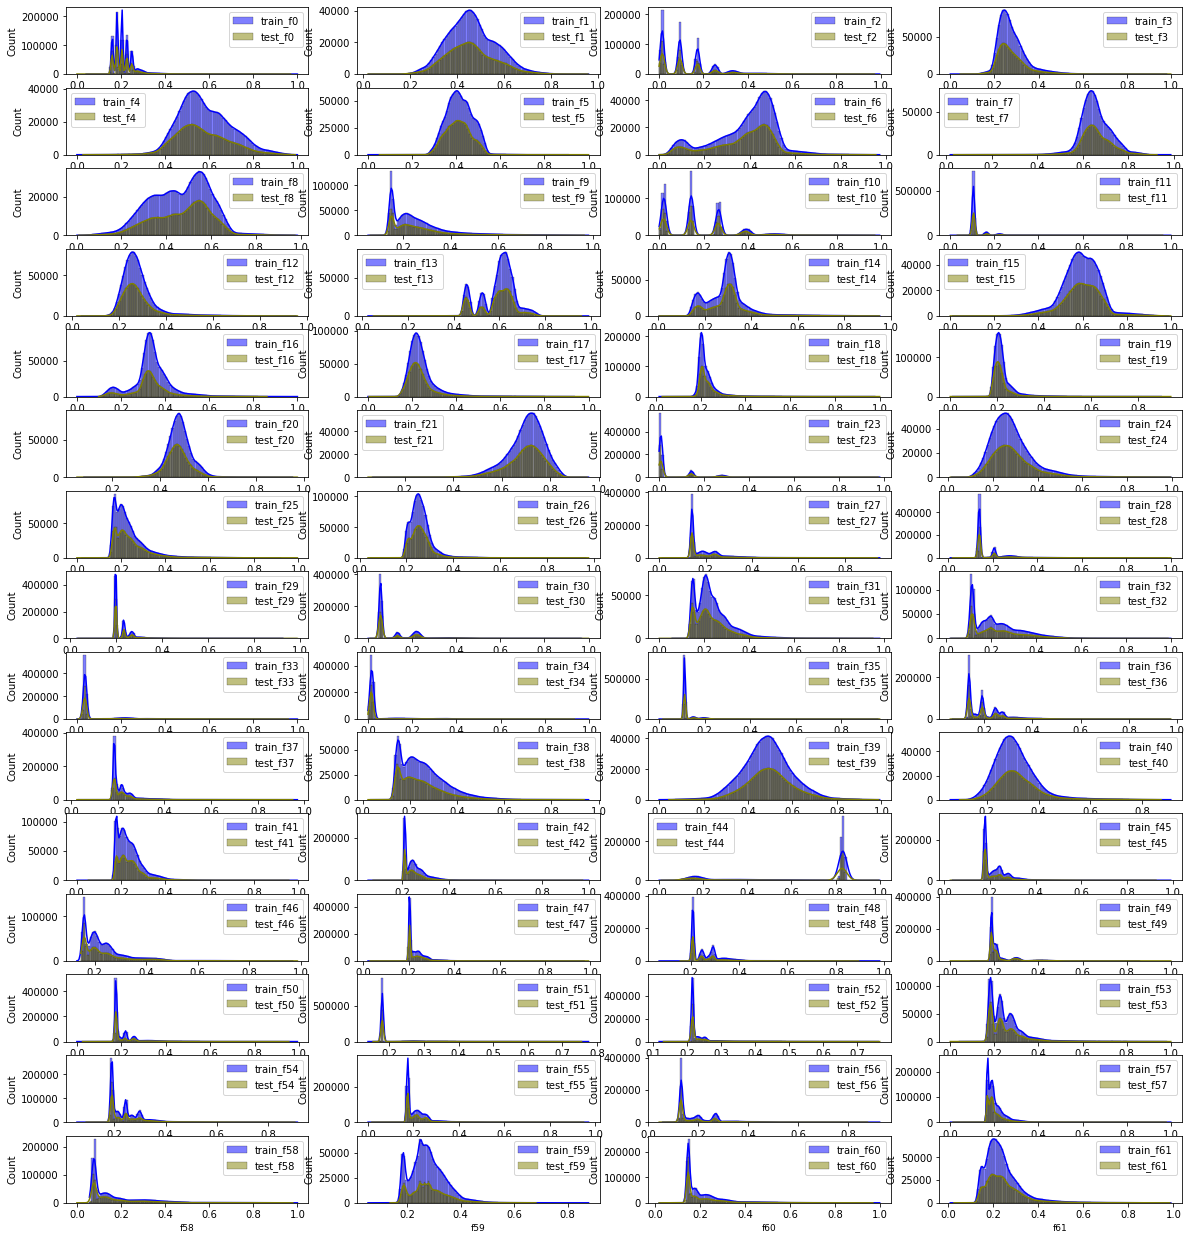

In [12]:
# plot the first 60 features 
i = 1
plt.figure()
fig, ax = plt.subplots(15, 4,figsize=(20, 22))
for feature in continous_cols[:60]:
    plt.subplot(15, 4,i)
    sns.histplot(train[feature],color="blue", kde=True,bins=100, label='train_'+feature)
    sns.histplot(test[feature],color="olive", kde=True,bins=100, label='test_'+feature)
    plt.xlabel(feature, fontsize=9); plt.legend()
    i += 1
plt.show()

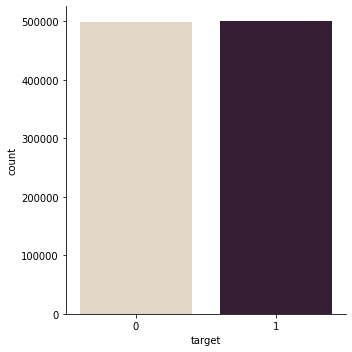

In [13]:
# Target distibution
sns.catplot(x="target", kind="count", palette="ch:.25", data=train)

# Modeling

In [7]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
train[continous_cols] = scaler.fit_transform(train[continous_cols])
test[continous_cols] = scaler.transform(test[continous_cols])

In [8]:
params={'reg_alpha': 8.158768860412389, 'reg_lambda': 8.793022151019823, 'colsample_bytree': 0.2, 'subsample': 0.4, 'learning_rate': 0.02,
       'max_depth': 100, 'num_leaves': 12, 'min_child_samples': 68, 'cat_smooth': 91,'objective': 'binary',  
            'random_state': 48,'n_estimators': 20000,'n_jobs': -1}

In [10]:
preds = np.zeros(test.shape[0])
kf = StratifiedKFold(n_splits=5,random_state=2021,shuffle=True)
auc=[]  # list contains auc for each fold
n=0
for trn_idx, test_idx in kf.split(train[cols],y):
    X_tr,X_val=train[cols].iloc[trn_idx],train[cols].iloc[test_idx]
    y_tr,y_val=y.iloc[trn_idx],y.iloc[test_idx]
    model = LGBMClassifier(**params)
    model.fit(X_tr,y_tr,eval_set=[(X_val,y_val)],early_stopping_rounds=100,eval_metric="auc",verbose=False)
    preds += model.predict_proba(test[cols])[:,1]/kf.n_splits
    auc.append(roc_auc_score(y_val, model.predict_proba(X_val)[:, 1]))
    gc.collect()
    print(f"fold: {n+1}, auc: {auc[n]}")
    n+=1  

fold: 1, auc: 0.8567715957363944
fold: 2, auc: 0.8570920386378991
fold: 3, auc: 0.8563049052972853
fold: 4, auc: 0.8582660763425511
fold: 5, auc: 0.8570853835316374


In [11]:
np.mean(auc)

0.8571039999091534

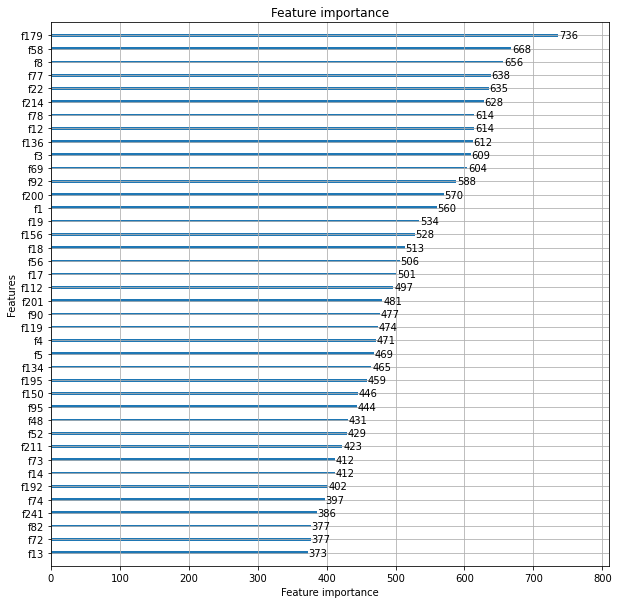

In [12]:
# most 40 important features for lgb model
from optuna.integration import lightgbm as lgb
lgb.plot_importance(model, max_num_features=40, figsize=(10,10))
plt.show()

# Making a Submission

In [13]:
sub['target']=preds
sub.to_csv('submission.csv', index=False)

In [14]:
sub

,id,target
0,1000000,0.756995
1,1000001,0.240903
2,1000002,0.901426
3,1000003,0.859380
4,1000004,0.252571
...,...,...
499995,1499995,0.969122
499996,1499996,0.819198
499997,1499997,0.300772
499998,1499998,0.506005


# I hope that you find this kernel usefull🏄